# Library

In [4]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# VAE

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fb30Uzl%2FbtrxY4wKngj%2FSucVwitDrRtQvi1xTHdrR0%2Fimg.png)

<br>

Variational Autoencoder (VAE)는 generative 모델의 한 정류. <br>
데이터의 latent representation을 학습하고, 이를 통해 새로운 데이터를 생성. <br>
Auto Encoder의 단점을 보완. <br>

## AE의 단점

|AE|VAE|
|--|---|
|<img src="https://tspinner.de/towards-an-interpretable-latent-space/images/distribution_AE.png" width=500 style="background: white">|<img src="https://tspinner.de/towards-an-interpretable-latent-space/images/distribution_VAE.png" width=500 style="background: white">|

<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*t03u0iy5jwkVDpFWuQUevQ.png" width=500>

<br>

representation 공간의 해석이 어려움. <br>
학습된 잠재공간이 연속적이지 않음. <br>
생성된 데이터가 원본 데이터와 비슷하지 않거나 품질이 낮음. <br>



## 방법

### Ratent Space에 대한 가정

<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*0epBx0akYt13XdDmAK1OLg.png" width=500>

<br>

<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*nVdUatQH2FxHEWiIy9xVxA.png" width=500>

<br>

<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*lXXZtrVWWvUoqq2G6tVwEw.png" width=500>

<br>

AE는 잠재공간에 대한 어떠한 제약도 없기에 학습을 통해 배워내는 잠재공간이 개별 포인트로 고정. <br> AE는 숫자 1을 생성하기 위한 공간을 하나의 특정 포인트로 인식. <br>

VAE는 이 잠재공간을 사람이 해석하기 좋은 형태로 가정. <br>
-> ex) 같은 숫자의 데이터 포인트는 인접한 공간에 모여 영역 형성. <br>
이 영역을 가우시안 분포를 통해 잠재공간을 나누어 데이터 포인트들을 연속적인 확률 분포로 나타냄.
- $ \mu $: 분포의 중심. 데이터의 대략적인 위치 결정. <br>
- $ \sigma $: 데이터가 평균을 중심으로 얼마나 떨어졌는지 결정. <br>





### Sampling

<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*7E1fqtq7pQ6WSakvLbpjKA.png" width=500>

<br>

오토인코더에서는 Encoder가 latent vector를 직접 연산. <br>
반면, VAE는 학습의 대상이 되는 vector 그 자체를 학습하는 것이 아닌, 가우시안 분포를 결정하는 𝜇(mean)와 𝜎(variance)를 학습. <br>
-> 확률 분포(gaussian distribution) 학습

하지만 decoder에서는 분포가 아닌 latent vector 필요. <br>
ex) 7을 표현하는 vector, 9를 표현하는 vector. 

<br>

<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*oaHMme6NMImPaYoOwjLtiA.png" width=500>

이를 해결하기 위해 sampling을 통해 vector를 얻어내고, 이를 decoder에 입력. <br>


### Reparametrization Trick

> $ z = \mu + \sigma * \epsilon $

forward 과정에서는 문제가 없으나, back propagation에서 sampling으로 인한 문제 발생. <br>
<- sampling은 random항이 포함되어 encoder의 network까지 역전파가 원활하지 않음. <br>

실제 구현에서는 수치적 안정성을 위해 variance를 log variance로 사용.

<br>

ex) 숫자 1의 학습 과정

$\epsilon$ 생성:
- 평균 0, 분산 1의 표준 정규 분포에서 생성된 변수.
- 역전파에서 영향을 받지 않는 상수로 간주.
    - encoder의 출력과 독립적 <br>
    -> $\epsilon$은 모델 학습 과정에서 고정된 형태로 존재. <br>
    -> 역전파 과정에서 $\mu$ 와 $\sigma$ 에 대한 그래디언트를 계산할 때 영향을 주지 않음.

encoder:
- 숫자 1이 인코더를 통해 latent vector로 변환.
- encoder는  $\mu$=1과  $\sigma^2$=0.3 추정.

sampling:
- $\epsilon$을 이용해 latent vector 계산.
- latent vector는 디코더의 입력으로 사용.

decoder:
- latent vector를 통해 1의 이미지 복원.

loss, back propagation:
- reconstructed image와 original image간 loss 계산.
- 역전파를 통해 모델 업데이트. KL 발산은 여기서 생략합니다.

sampling 과정을 **역전파가 가능하도록 변환**하여, 모델이 무작위성을 효과적으로 처리하고 안정적으로 학습할 수 있도록 함.

### ELBO

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2Fc16cvR%2Fbtrx2S2swBW%2FrJtpTy6nua2okf2EU8RfKK%2Fimg.png" width=500>

<img src="https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbLHTOd%2Fbtrx0uuZIcl%2FS6QxALD6SQPPF5cE8Z7qS0%2Fimg.png" width=500>


## Practice

In [11]:
class Encoder(nn.Module):
    def __init__(self, configs={}):
        super().__init__()
        self.configs = configs
        self.hidden_dim = self.configs.get('hidden_dim', 128)
        self.latent_dim = self.configs.get('latent_dim', 20)

        self.fc1 = nn.Linear(28*28, self.hidden_dim)
        self.mu = nn.Linear(self.hidden_dim, self.latent_dim)
        self.sigma = nn.Linear(self.hidden_dim, self.latent_dim)

    def forward(self, x):
        x = self.fc1(x)

        mu = self.mu(x)
        sigma = self.sigma(x)

        return mu, sigma

In [10]:
class Decoder(nn.Module):
    def __init__(self, configs={}):
        super().__init__()
        self.configs = configs
        self.hidden_dim = self.configs.get('hidden_dim', 128)
        self.latent_dim = self.configs.get('latent_dim', 20)

        self.fc1 = nn.Linear(self.latent_dim, self.hidden_dim)
        self.fc2 = nn.Linear(self.hidden_dim, 28*28)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)

        return x

In [12]:
encoder = Encoder()
decoder = Decoder()

In [13]:
x = torch.randn(32, 28*28)
mu, log_var = encoder(x)

In [ ]:
z = mu + log_var * torch.randn(32, 20)
decoder(z).reshape(32, 1, 28, -1)

In [27]:
class VAE(nn.Module):
    def __init__(self, configs={}):
        super().__init__()
        self.configs = configs

        self.encoder = Encoder(self.configs)
        self.decoder = Decoder(self.configs)
    
    def reparameterize(self, mu, log_var):
        sigma = torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(sigma)

        return mu + sigma*epsilon

    def forward(self, x):
        mu, log_var = self.encoder(x)
        z = self.reparameterize(mu, log_var)
        x_reconstructed = self.decoder(z)

        loss = self.loss(x, x_reconstructed, mu, log_var)

        return loss
        
    def loss(self, x, x_reconstructed, mu, log_var):
        # reconstructed error (BCE)
        BCE = F.mse_loss(x_reconstructed, x)

        # KL divergence
        KL = -0.5 + (1 + log_var + mu.pow(2) - log_var.exp()).sum()

        return BCE + KL

In [ ]:
vae = VAE()
vae(x)

tensor(33.6825, grad_fn=<AddBackward0>)

In [24]:
from vae.src.training import MNISTModule
from vae.src.model.vae import Encoder, Decoder, VAE

In [25]:
configs = {}
encoder = Encoder(configs)
Decoder = Decoder(configs)
model = VAE(encoder, decoder)

In [27]:
vae = MNISTModule.load_from_checkpoint(
    r'C:\Users\USER\.vscode\git\SKN\tensorboard\MNIST\batch_size=256,learning_rate=0.004,dropout_ratio=0.3,device=cpu,input_dim=784\version_1\checkpoints\epoch=63-step=12032.ckpt',
    model=model,
    learning_rate=4e-3,
)

In [8]:
torch.randn(32, 20).shape

torch.Size([32, 20])

In [28]:
with torch.no_grad():
    images_negerated = vae.model.decoder(torch.randn(32, 20)).reshape(32, 28, 28)

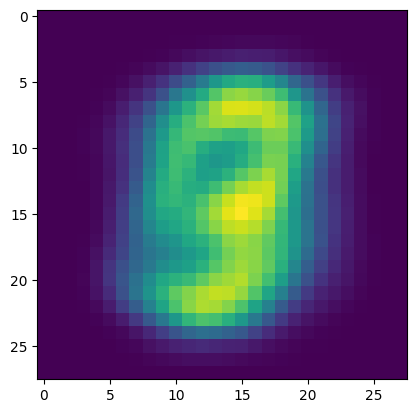

In [29]:
plt.imshow(images_negerated[10])